In the paper [MotionTTT: 2D Test-Time-Training Motion Estimation for 3D Motion Corrected MRI](https://arxiv.org/abs/2409.09370) we propose MotionTTT for estimating motion parameters in 3D MRI using a U-net pre-trained on the task of motion-free 2D reconstruction form undersampled MRI measurements.

For both pre-training on motion-free 2D slices and testing our method on 3D volumes with simulated motion parameters we use the data provided in the training and validation set of the [Calgary Campinas Brain MRI Dataset (CC359)](https://portal.conp.ca/dataset?id=projects/calgary-campinas#).


The CC359 dataset contains hybrid 3D k-spaces with two axes in the Fourier domain and one axis in the spatial domain. **In this notebook** we show 
- how we pre-processed the data to obtain a 3D k-space in the Fourier domain, which we will use to generate undersampled 2D training slices and motion corrupted 3D test volumes, 
- and how we pre-compute sensitivity maps.

In [1]:
import torch
import h5py
import pathlib
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('./codebase/')

### after install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/tobit/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/tobit/bart-0.7.00/"
import bart

from codebase.functions.utils.helpers.helpers_math import fft2c_ndim, ifft2c_ndim, complex_abs
from codebase.functions.utils.data.transforms import to_tensor

Set `input_dir_train` and `input_dir_val` to data downloaded from the [Calgary Campinas Brain MRI Dataset (CC359)](https://portal.conp.ca/dataset?id=projects/calgary-campinas#). The training/validation set should contain 47/20 volumes of which 40/16 have a y-axis resolution of 170 and 7/4 a y-axis resolution of 180. We only use the volumes with resolution 170.

In [2]:
input_dir_train = "/media/ssd3/cc-359_raw/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel/Train/"
output_dir_train = "/media/ssd3/cc-359_raw/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel/Train_converted/"
output_dir_train_smaps = "/media/ssd3/cc-359_raw/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel/Train_s_maps_3D/"
os.makedirs(output_dir_train, exist_ok=True)
os.makedirs(output_dir_train_smaps, exist_ok=True)

input_dir_val = "/media/ssd3/cc-359_raw/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel/Val/"
output_dir_val = "/media/ssd3/cc-359_raw/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel/Val_converted/"
output_dir_val_smaps = "/media/ssd3/cc-359_raw/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel/Val_s_maps_3D/"
os.makedirs(output_dir_val, exist_ok=True)
os.makedirs(output_dir_val_smaps, exist_ok=True)

mri_files_train = list(pathlib.Path(input_dir_train).glob('*.h5'))
mri_files_val = list(pathlib.Path(input_dir_val).glob('*.h5'))

print(f"Trainset contains {len(mri_files_train)} volumes, valset contains {len(mri_files_val)} volumes.")


# Load mask to mask k-space before computing the coil sensitivity maps
with open("./codebase/data_files/mask_3D_size_218_170_256_R_4_poisson_disc.pickle", 'rb') as handle:
    mask = pickle.load(handle)

Trainset contains 47 volumes, valset contains 20 volumes.


Compute and save converted k-space and compute sensitivity maps for the training set

In [ ]:
count = 0
for mri_f in mri_files_train:

    with h5py.File(mri_f, 'r') as hf:
        kspace_hf = hf['kspace'][()]

    if kspace_hf.shape[2] == 180:
        continue
    kspace_torch = torch.from_numpy(kspace_hf)

    # # Separate real and imaginary parts
    kspace_torch_cpx = torch.stack([kspace_torch[...,::2], kspace_torch[...,1::2]], dim=-1).moveaxis(3,1)

    # # Set values that to zero are not zero due to numerical reasons but should be zero
    # due to partial Fourier sampling along the y-axis.
    partial_fourier_sampling_start_index = torch.where(torch.abs(kspace_torch_cpx[0,0,0,:,0]) < 1)[0][0]-1
    kspace_torch_cpx[:,:,:,partial_fourier_sampling_start_index:,:] = 0.0
    kspace_torch_cpx = kspace_torch_cpx.moveaxis(0,-2)

    # re-arrange data to obtain a coherent spatial 3D volume
    kspace_torch_cpx_3D = fft2c_ndim(kspace_torch_cpx, 1)
    img_torch_cpx_3D = ifft2c_ndim(kspace_torch_cpx_3D, 3)
    img_torch_cpx_3D_shifted = torch.fft.ifftshift(img_torch_cpx_3D, dim=(-4,-3))

    kspace_torch_cpx_3D_recon = fft2c_ndim(img_torch_cpx_3D_shifted, 3)
    kspace_torch_cpx_3D_recon[:,:,partial_fourier_sampling_start_index:,:,:] = 0.0
    
    save_file = os.path.join(output_dir_train, str(mri_f.name))

    # # The saved k-space has dimensions (coil, x, y, z, complex) = (12, 218, 170, 256, 2)
    data = h5py.File(save_file, 'w')
    data.create_dataset('kspace', data=kspace_torch_cpx_3D_recon)
    data.close()

    # # Compute sens maps
    masked_k_space = kspace_torch_cpx_3D_recon * torch.from_numpy(mask).unsqueeze(0).unsqueeze(-1)

    masked_k_space_1c = masked_k_space[...,0] + 1j*masked_k_space[...,1]
    sens_maps = bart.bart(1, f'ecalib -d0 -m1', masked_k_space_1c.moveaxis(0,-1).numpy())

    sens_maps_torch = to_tensor(sens_maps).moveaxis(-2,0)

    save_file = os.path.join(output_dir_train_smaps, "smaps_"+str(mri_f.name))

    data = h5py.File(save_file, 'w')
    data.create_dataset('smaps', data=sens_maps_torch)
    data.close()

    count += 1
    print(f"{count} volumes processed")


Repeat for validation data

In [ ]:
count = 0
for mri_f in mri_files_val:

    with h5py.File(mri_f, 'r') as hf:
        kspace_hf = hf['kspace'][()]

    if kspace_hf.shape[2] == 180:
        continue
    kspace_torch = torch.from_numpy(kspace_hf)

    # # Separate real and imaginary parts
    kspace_torch_cpx = torch.stack([kspace_torch[...,::2], kspace_torch[...,1::2]], dim=-1).moveaxis(3,1)

    # # Set values that to zero are not zero due to numerical reasons but should be zero
    # due to partial Fourier sampling along the y-axis.
    partial_fourier_sampling_start_index = torch.where(torch.abs(kspace_torch_cpx[0,0,0,:,0]) < 1)[0][0]-1
    kspace_torch_cpx[:,:,:,partial_fourier_sampling_start_index:,:] = 0.0
    kspace_torch_cpx = kspace_torch_cpx.moveaxis(0,-2)

    # re-arrange data to obtain a coherent spatial 3D volume
    kspace_torch_cpx_3D = fft2c_ndim(kspace_torch_cpx, 1)
    img_torch_cpx_3D = ifft2c_ndim(kspace_torch_cpx_3D, 3)
    img_torch_cpx_3D_shifted = torch.fft.ifftshift(img_torch_cpx_3D, dim=(-4,-3))

    kspace_torch_cpx_3D_recon = fft2c_ndim(img_torch_cpx_3D_shifted, 3)
    kspace_torch_cpx_3D_recon[:,:,partial_fourier_sampling_start_index:,:,:] = 0.0
    
    save_file = os.path.join(output_dir_val, str(mri_f.name))

    # # The saved k-space has dimensions (coil, x, y, z, complex) = (12, 218, 170, 256, 2)
    data = h5py.File(save_file, 'w')
    data.create_dataset('kspace', data=kspace_torch_cpx_3D_recon)
    data.close()

    # # Compute sens maps
    masked_k_space = kspace_torch_cpx_3D_recon * torch.from_numpy(mask).unsqueeze(0).unsqueeze(-1)

    masked_k_space_1c = masked_k_space[...,0] + 1j*masked_k_space[...,1]
    sens_maps = bart.bart(1, f'ecalib -d0 -m1', masked_k_space_1c.moveaxis(0,-1).numpy())

    sens_maps_torch = to_tensor(sens_maps).moveaxis(-2,0)

    save_file = os.path.join(output_dir_val_smaps, "smaps_"+str(mri_f.name))

    data = h5py.File(save_file, 'w')
    data.create_dataset('smaps', data=sens_maps_torch)
    data.close()

    count += 1
    print(f"{count} volumes processed")

Display some data

Load k-space from /media/ssd3/cc-359_raw/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel/Val_converted/e14498s5_P60928.7.h5


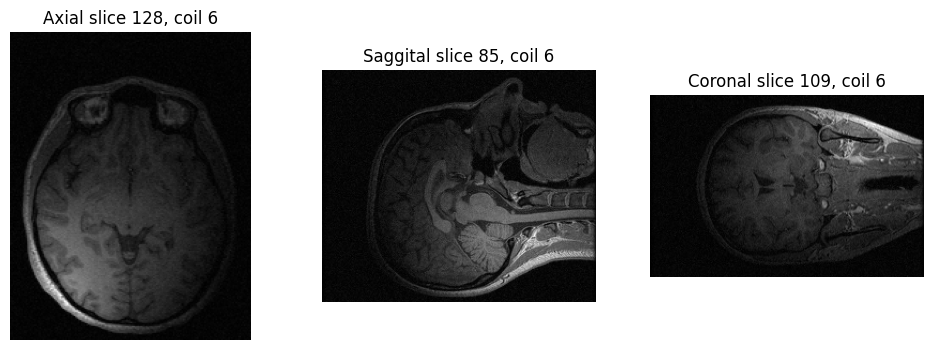

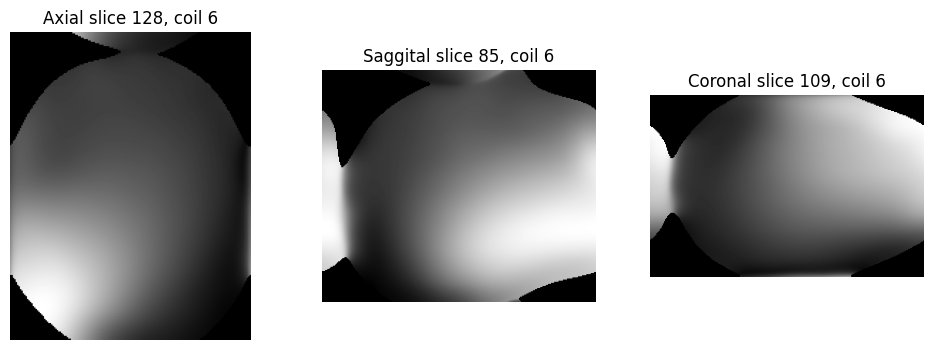

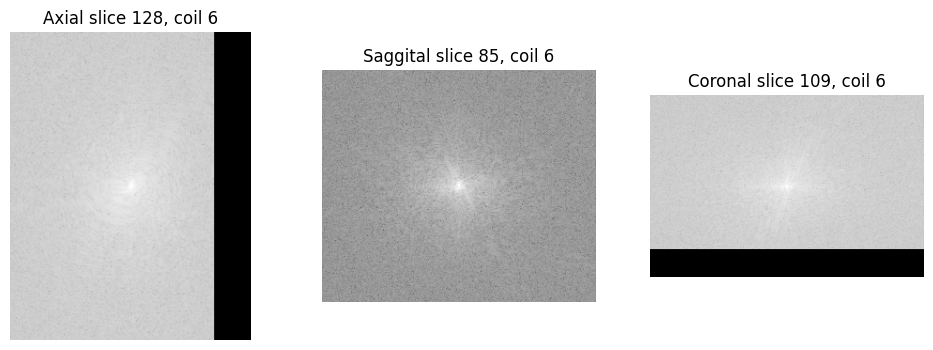

In [5]:
processed_kspaces_val = list(pathlib.Path(output_dir_val).glob('*.h5'))

print(f"Load k-space from {processed_kspaces_val[0]}")
with h5py.File(processed_kspaces_val[0], 'r') as hf:
        kspace_hf = hf['kspace'][()]

with h5py.File(os.path.join(output_dir_val_smaps,"smaps_"+processed_kspaces_val[0].name), 'r') as hf:
        smaps_hf = hf['smaps'][()]
        
kspace = torch.from_numpy(kspace_hf)
img = ifft2c_ndim(kspace, 3)
smaps = torch.from_numpy(smaps_hf)

coil_ind = 6

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(complex_abs(img)[coil_ind, :, :, img.shape[3]//2].numpy(), cmap='gray')
axs[0].set_title(f'Axial slice {img.shape[3]//2}, coil {coil_ind}')
axs[0].axis('off')
axs[1].imshow(complex_abs(img)[coil_ind, :, img.shape[2]//2, :].numpy(), cmap='gray')
axs[1].set_title(f'sagittal slice {img.shape[2]//2}, coil {coil_ind}')
axs[1].axis('off')
axs[2].imshow(complex_abs(img)[coil_ind, img.shape[1]//2, :, :].numpy(), cmap='gray')
axs[2].set_title(f'Coronal slice {img.shape[1]//2}, coil {coil_ind}')
axs[2].axis('off')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(complex_abs(smaps)[coil_ind, :, :, img.shape[3]//2].numpy(), cmap='gray')
axs[0].set_title(f'Axial slice {img.shape[3]//2}, coil {coil_ind}')
axs[0].axis('off')
axs[1].imshow(complex_abs(smaps)[coil_ind, :, img.shape[2]//2, :].numpy(), cmap='gray')
axs[1].set_title(f'sagittal slice {img.shape[2]//2}, coil {coil_ind}')
axs[1].axis('off')
axs[2].imshow(complex_abs(smaps)[coil_ind, img.shape[1]//2, :, :].numpy(), cmap='gray')
axs[2].set_title(f'Coronal slice {img.shape[1]//2}, coil {coil_ind}')
axs[2].axis('off')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(np.log(complex_abs(kspace)[coil_ind, :, :, img.shape[3]//2].numpy()+1e-9), cmap='gray')
axs[0].set_title(f'Axial slice {img.shape[3]//2}, coil {coil_ind}')
axs[0].axis('off')
axs[1].imshow(np.log(complex_abs(kspace)[coil_ind, :, img.shape[2]//2, :].numpy()+1e-9), cmap='gray')
axs[1].set_title(f'sagittal slice {img.shape[2]//2}, coil {coil_ind}')
axs[1].axis('off')
axs[2].imshow(np.log(complex_abs(kspace)[coil_ind, img.shape[1]//2, :, :].numpy()+1e-9), cmap='gray')
axs[2].set_title(f'Coronal slice {img.shape[1]//2}, coil {coil_ind}')
axs[2].axis('off')
plt.show()


